In [1]:
import numpy as np
import xarray as xr

In [2]:
ds = xr.open_dataset('/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/data/ECMWF_TROP_202402151200_202402151200_1.nc', chunks={})
ds

<xarray.Dataset> Size: 29GB
Dimensions:    (time: 1, level: 137, latitude: 2560, longitude: 5120)
Coordinates:
  * longitude  (longitude) float32 20kB 2.501e-07 0.07031 0.1406 ... 359.9 359.9
  * latitude   (latitude) float32 10kB 89.95 89.88 89.81 ... -89.88 -89.95
  * level      (level) int32 548B 1 2 3 4 5 6 7 ... 131 132 133 134 135 136 137
  * time       (time) datetime64[ns] 8B 2024-02-15T12:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 7GB dask.array<chunksize=(1, 28, 512, 1024), meta=np.ndarray>
    t          (time, level, latitude, longitude) float32 7GB dask.array<chunksize=(1, 28, 512, 1024), meta=np.ndarray>
    q          (time, level, latitude, longitude) float32 7GB dask.array<chunksize=(1, 28, 512, 1024), meta=np.ndarray>
    lnsp       (time, level, latitude, longitude) float32 7GB dask.array<chunksize=(1, 28, 512, 1024), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2025-03-04 22:54:08 GMT by grib_to_netcdf-2.28.1: grib_to_n...

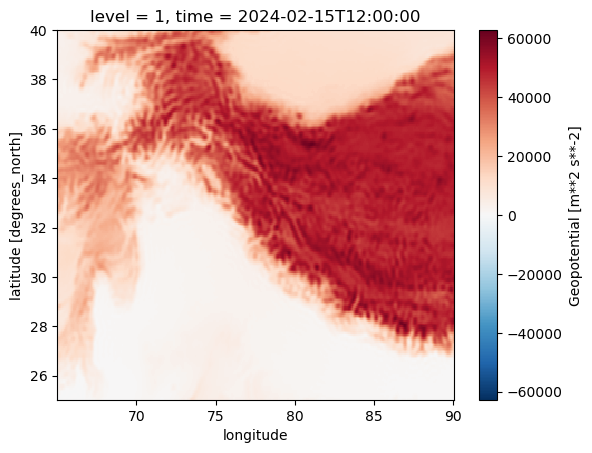

In [4]:
%matplotlib inline
ds.isel(time=0, level=0).z.sel(longitude=slice(65, 90), latitude=slice(40, 25)).plot.imshow()

In [31]:
ds.sel(longitude=slice(65, 85), latitude=slice(40, 25)).to_netcdf('/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/tropo/tests/data/test_data.nc')

In [4]:
from opera_tropo.core import calculate_ztd

In [32]:
%%time
out_ds = calculate_ztd(ds.sel(longitude=slice(65, 85), latitude=slice(40, 25)))

CPU times: user 16.3 s, sys: 6.69 s, total: 23 s
Wall time: 22.4 s


In [34]:
out_ds.to_netcdf('/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/tropo/tests/data/output_data.nc')

In [2]:
ds1 = xr.open_dataset('/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/tropo/tests/data/test_data.nc')

In [3]:
ds1

<xarray.Dataset> Size: 133MB
Dimensions:    (time: 1, level: 137, latitude: 213, longitude: 284)
Coordinates:
  * longitude  (longitude) float32 1kB 65.04 65.11 65.18 ... 84.8 84.87 84.94
  * latitude   (latitude) float32 852B 39.96 39.89 39.82 ... 25.2 25.13 25.06
  * level      (level) int32 548B 1 2 3 4 5 6 7 ... 131 132 133 134 135 136 137
  * time       (time) datetime64[ns] 8B 2024-02-15T12:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 33MB ...
    t          (time, level, latitude, longitude) float32 33MB ...
    q          (time, level, latitude, longitude) float32 33MB ...
    lnsp       (time, level, latitude, longitude) float32 33MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2025-03-04 22:54:08 GMT by grib_to_netcdf-2.28.1: grib_to_n...

# RAIDER


In [4]:
from RAiDER.models import HRES

In [652]:
hres_model = HRES()

# Extract temperature and specific humidity at the first time step
hres_model._t = ds1.t.isel(time=0).values
hres_model._q = ds1.q.isel(time=0).values

# Extract longitude and latitude values
longitude = ds1.longitude.values
latitude = ds1.latitude.values

# Use geopotential heights and log of surface pressure
# to get pressure, geopotential, and geopotential height
_, pres, hgt = hres_model._calculategeoh(
        ds1.z.isel(time=0, level=0).values,
        ds1.lnsp.isel(time=0, level=0).values
)
hres_model._p = pres

In [653]:
# Create latitude and longitude grid
hres_model._lons, hres_model._lats = np.meshgrid(longitude, latitude)

# Get altitudes
hres_model._get_heights(hres_model._lats, hgt.transpose(1, 2, 0))
h = hres_model._zs.copy()

# Re-structure arrays from (heights, lats, lons) to (lons, lats, heights)
hres_model._p = np.flip(hres_model._p.transpose(1, 2, 0), axis=2)
hres_model._t = np.flip(hres_model._t.transpose(1, 2, 0), axis=2)
hres_model._q = np.flip(hres_model._q.transpose(1, 2, 0), axis=2)
hres_model._zs = np.flip(h, axis=2)
hres_model._xs, hres_model._ys = hres_model._lons.copy(), hres_model._lats.copy()



In [ ]:
# Perform RAiDER computations
hres_model._find_e()  # Compute partial pressure of water vapor
hres_model._uniform_in_z(_zlevels=None)

hres_model._checkForNans()

In [7]:
#Partial pressure is on the height levels 145
hres_model._e.shape


(213, 284, 145)

In [8]:
hres_model._get_wet_refractivity()
hres_model._get_hydro_refractivity()
hres_model._adjust_grid(hres_model.get_latlon_bounds())

# Compute zenith delays at the weather model grid nodes
hres_model._getZTD()